notebook to verify, preprocess, and analyze conversion data!

1. combine everything into a dataframe and validate/do sanity checks to ensure everything looks good

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import glob
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# All models (excluding broken qwen3-235b)
NON_REASONING_MODELS = ['gpt-4o', 'qwen-coder', 'llama-4']
REASONING_MODELS = ['gpt-5.2', 'deepseek-v3.1', 'qwen3-235b-thinking', 'qwen3-next-thinking']
ALL_MODELS = NON_REASONING_MODELS + REASONING_MODELS

# Conditions mapped to subdirectories
CONDITIONS = {
    'regular':   'results',
    'no_guide':  'results_no_guide',
    'math_only': 'results_math_only',
}

# Nice display names & colors
MODEL_DISPLAY = {
    'gpt-4o': 'GPT-4o',
    'qwen-coder': 'Qwen3-Coder-480B',
    'llama-4': 'Llama-4-Maverick',
    'gpt-5.2': 'GPT-5.2 ★',
    'deepseek-v3.1': 'DeepSeek-V3.1 ★',
    'qwen3-235b-thinking': 'Qwen3-235B-Think ★',
    'qwen3-next-thinking': 'Qwen3-Next-Think ★',
}

MODEL_COLORS = {
    'gpt-4o': '#1f77b4',
    'qwen-coder': '#ff7f0e',
    'llama-4': '#2ca02c',
    'gpt-5.2': '#d62728',
    'deepseek-v3.1': '#9467bd',
    'qwen3-235b-thinking': '#8c564b',
    'qwen3-next-thinking': '#e377c2',
}

print(f"Non-reasoning models: {NON_REASONING_MODELS}")
print(f"Reasoning models:     {REASONING_MODELS}")

Non-reasoning models: ['gpt-4o', 'qwen-coder', 'llama-4']
Reasoning models:     ['gpt-5.2', 'deepseek-v3.1', 'qwen3-235b-thinking', 'qwen3-next-thinking']


load the existing results

one file now yay!

In [3]:
df_all = pd.read_csv('/data/jane/convert/math_gender/conversion_test/full_results/clean_results.tsv', sep='\t', low_memory=False)
print(f"loaded {len(df_all):,} rows from clean_results.tsv")

loaded 2,748,418 rows from clean_results.tsv


In [ ]:
# need to exclude qwen3-235b because it's broken
df_all = df_all[df_all['model'] != 'qwen3-235b']

In [5]:
df_all.columns

Index(['domain', 'distractor', 'prompt', 'number', 'answer', 'difficulty',
       'raw_response', 'model_answer', 'loss', 'reasoning_tokens',
       'call_seconds', 'model', 'condition'],
      dtype='object')

In [6]:
# make sure that worked lol
df_all.head()

,domain,distractor,prompt,number,answer,difficulty,raw_response,model_answer,loss,reasoning_tokens,call_seconds,model,condition
0,bits_bytes,NaN,Convert 1 bit to byte.\n\nConversion guide:\nC...,1.0,0.125,Easy,<answer>0.125</answer>,0.125,0.0,0.0,1.260889,deepseek-v3.1,regular
1,bits_bytes,NaN,Convert 2 bits to bytes.\n\nConversion guide:\...,2.0,0.25,Easy,<answer>0.25</answer>,0.25,0.0,0.0,1.336294,deepseek-v3.1,regular
2,bits_bytes,NaN,Convert 3 bits to bytes.\n\nConversion guide:\...,3.0,0.375,Easy,<answer>0.375</answer>,0.375,0.0,0.0,1.258817,deepseek-v3.1,regular
3,bits_bytes,NaN,Convert 4 bits to bytes.\n\nConversion guide:\...,4.0,0.5,Easy,<answer>0.5</answer>,0.5,0.0,0.0,1.245189,deepseek-v3.1,regular
4,bits_bytes,NaN,Convert 5 bits to bytes.\n\nConversion guide:\...,5.0,0.625,Easy,<answer>0.625</answer>,0.625,0.0,0.0,1.776559,deepseek-v3.1,regular


In [7]:
df_all['is_reasoning'] = df_all['model'].isin(REASONING_MODELS)
df_all['display_name'] = df_all['model'].map(MODEL_DISPLAY)

In [8]:
# check cols, length of data, and some other things

if df_all is not None:
    print(f"loaded {len(df_all):,} rows")
    print(f"columns: {df_all.columns.tolist()}")
    print(f"models: {df_all['model'].unique()}")
    print(f"conditions: {df_all['condition'].unique()}")
    print(f"domains: {df_all['domain'].unique()}")

df_all.columns

loaded 2,665,611 rows
columns: ['domain', 'distractor', 'prompt', 'number', 'answer', 'difficulty', 'raw_response', 'model_answer', 'loss', 'reasoning_tokens', 'call_seconds', 'model', 'condition', 'is_reasoning', 'display_name']
models: ['deepseek-v3.1' 'gpt-4o' 'gpt-5.2' 'llama-4' 'qwen-coder'
 'qwen3-235b-thinking' 'qwen3-next-thinking']
conditions: ['regular' 'math_only' 'no_guide']
domains: ['bits_bytes' 'clothing_sizes_men_pant_size'
 'clothing_sizes_men_shoe_size' 'clothing_sizes_women_bra_size'
 'clothing_sizes_women_pant_size' 'clothing_sizes_women_shoe_size'
 'cooking' 'currency' 'density' 'energy' 'moles_to_particles' 'speed'
 'temperature' 'timezone' 'volume']


Index(['domain', 'distractor', 'prompt', 'number', 'answer', 'difficulty',
       'raw_response', 'model_answer', 'loss', 'reasoning_tokens',
       'call_seconds', 'model', 'condition', 'is_reasoning', 'display_name'],
      dtype='object')

In [9]:
df_all.groupby(['model','condition','domain']).size().to_frame('count').reset_index()

,model,condition,domain,count
0,deepseek-v3.1,math_only,bits_bytes,1200
1,deepseek-v3.1,math_only,cooking,1200
2,deepseek-v3.1,math_only,currency,1800
3,deepseek-v3.1,math_only,density,1200
4,deepseek-v3.1,math_only,energy,2000
...,...,...,...,...
255,qwen3-next-thinking,regular,clothing_sizes_women_pant_size,31
256,qwen3-next-thinking,regular,cooking,37200
257,qwen3-next-thinking,regular,currency,1800
258,qwen3-next-thinking,regular,density,37200


In [10]:
# sampling from energy domain to look at loss, as one example
df_all[df_all['domain']=='energy'][['raw_response', 'model_answer','answer','loss']].sample(10)

,raw_response,model_answer,answer,loss
1282670,NaN,NaN,47.00724,NaN
1929302,<answer>0.112003815</answer>,0.112003815,0.1120085286471138,0.0
1881184,<answer>8.604774535809856</answer>,8.604774535809856,8.604206500956023,0.0
1417585,NaN,NaN,0.059284,NaN
2086713,35.8509,35.8509,35.85086042065009,0.0
1546629,<answer>0.096</answer>,0.096,0.096,0.0
1112600,NaN,NaN,396000.7571716198,NaN
851129,13.6943,13.6943,13.693833652007648,0.0
2315583,0.0450,0.045,0.045,0.0
2288515,438.5712,438.5712,438.60872,0.0


note to self/reader: 

loss is computed in different ways depending on domain.
numerical: loss is the relative percentage error between real and model answer, unless those are within a 1% error, in which case loss = 0.0.
timezone: loss is # of minutes difference between real and model answer. if they are 1 minute off, loss is 0.0.
clothing size: binary loss. 1 if incorrect, 0 if correct.

*data cleaning (timezone ground truth, math_only timezone extraction, bra_size extraction) is handled in `clean_results.ipynb`*

**calculate accuracy and other statistics**

In [11]:
# show average loss by domain, model, condition
df_all.groupby(['domain','model','condition']).agg({'loss': 'mean'}).reset_index()

,domain,model,condition,loss
0,bits_bytes,deepseek-v3.1,math_only,2.475000e-01
1,bits_bytes,deepseek-v3.1,no_guide,7.973594e+07
2,bits_bytes,deepseek-v3.1,regular,1.181158e+01
3,bits_bytes,gpt-4o,math_only,4.164511e+02
4,bits_bytes,gpt-4o,no_guide,5.879706e+00
...,...,...,...,...
255,volume,qwen-coder,no_guide,6.721651e+06
256,volume,qwen-coder,regular,2.228770e+01
257,volume,qwen3-235b-thinking,math_only,0.000000e+00
258,volume,qwen3-235b-thinking,no_guide,0.000000e+00


In [12]:
# calculate accuracy/correctness based on loss
df_all['is_correct'] = df_all['loss'] == 0.0

# show accuracy by domain, model, condition
df_all.groupby(['domain','model','condition'])['is_correct'].mean().mul(100).reset_index(name='accuracy_%')


,domain,model,condition,accuracy_%
0,bits_bytes,deepseek-v3.1,math_only,99.750000
1,bits_bytes,deepseek-v3.1,no_guide,63.000000
2,bits_bytes,deepseek-v3.1,regular,83.916667
3,bits_bytes,gpt-4o,math_only,89.750000
4,bits_bytes,gpt-4o,no_guide,48.833333
...,...,...,...,...
255,volume,qwen-coder,no_guide,85.462366
256,volume,qwen-coder,regular,66.456989
257,volume,qwen3-235b-thinking,math_only,16.666667
258,volume,qwen3-235b-thinking,no_guide,1.612903


In [13]:
# check overall accuracy by model, condition
df_all.groupby(['model','condition'])['is_correct'].mean().mul(100).reset_index(name='accuracy_%')

,model,condition,accuracy_%
0,deepseek-v3.1,math_only,95.358333
1,deepseek-v3.1,no_guide,79.149056
2,deepseek-v3.1,regular,71.455828
3,gpt-4o,math_only,90.416667
4,gpt-4o,no_guide,80.532984
5,gpt-4o,regular,71.757880
6,gpt-5.2,math_only,96.058333
7,gpt-5.2,no_guide,87.731803
8,gpt-5.2,regular,80.616165
9,llama-4,math_only,88.541667


In [14]:
# make stats dataframe
df_stats = (
    df_all
    .groupby(['model', 'condition', 'domain'])['is_correct']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'accuracy', 'count': 'n'})
    .reset_index()
)

df_stats.head()

,model,condition,domain,accuracy,n
0,deepseek-v3.1,math_only,bits_bytes,0.997500,1200
1,deepseek-v3.1,math_only,cooking,0.989167,1200
2,deepseek-v3.1,math_only,currency,0.989444,1800
3,deepseek-v3.1,math_only,density,0.974167,1200
4,deepseek-v3.1,math_only,energy,0.986500,2000


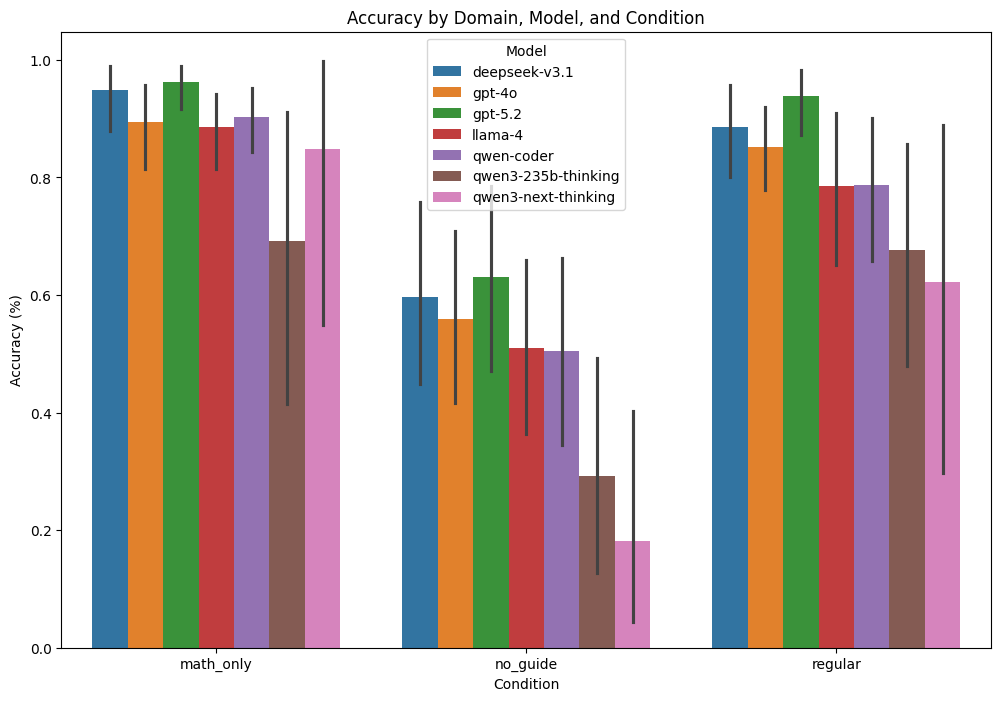

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# make a seaborn bar plot of accuracy by model, condition
plt.figure(figsize=(12, 8))
sns.barplot(data=df_stats, x='condition', y='accuracy', hue='model')
plt.title('Accuracy by Domain, Model, and Condition')
plt.xlabel('Condition')
plt.ylabel('Accuracy (%)')
plt.legend(title='Model')
plt.show()

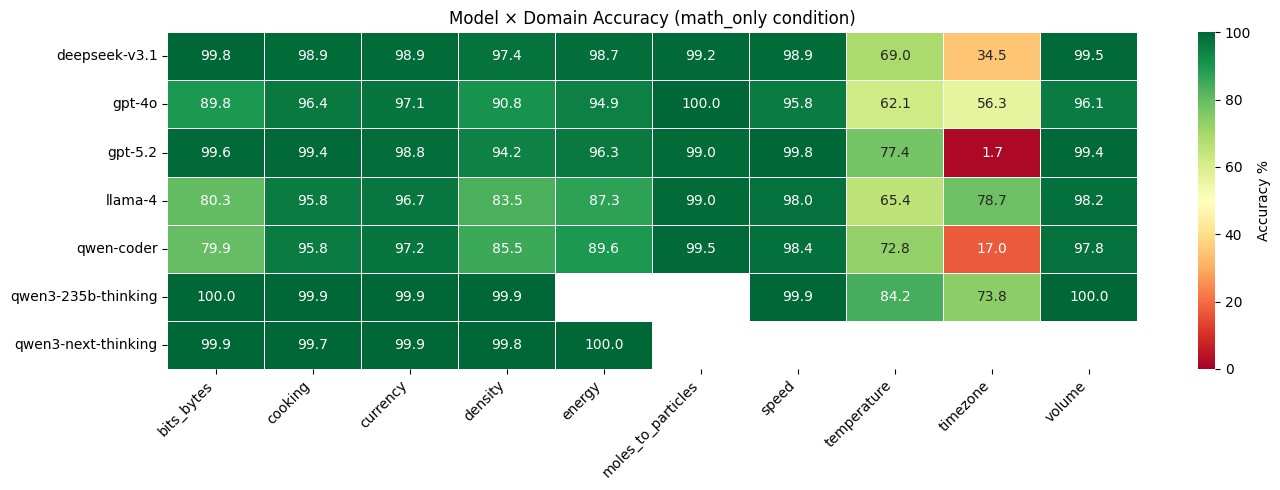

In [ ]:
# make a math only heatmap of accuracy by model, condition
heatmap_data = (
    df_stats[df_stats['condition'] == 'math_only']
    .pivot(index='model', columns='domain', values='accuracy_%')
)

plt.figure(figsize=(14, 5))
sns.heatmap(
    heatmap_data,
    annot=True, fmt='.1f',       # show numbers in cells
    cmap='RdYlGn',               # red=bad, green=good
    vmin=0, vmax=100,            # fix scale to 0-100%
    linewidths=0.5,
    cbar_kws={'label': 'Accuracy %'},
)
plt.title('Model × Domain Accuracy (math_only condition)')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [ ]:
# show timezone and math only entries

df_all[(df_all['domain']=='timezone') & (df_all['condition']=='math_only')]


,domain,distractor,prompt,number,answer,difficulty,raw_response,model_answer,loss,model,condition,reasoning_tokens,call_seconds,is_reasoning,display_name,is_correct
1345628,timezone,NaN,what is (1+3.0)%24,1AM,4AM,Easy,<answer>4</answer>,NaN,NaN,deepseek-v3.1,math_only,0.0,0.738050,True,DeepSeek-V3.1 ★,False
1345629,timezone,NaN,what is (2+3.0)%24,2AM,5AM,Easy,<answer>5</answer>,NaN,NaN,deepseek-v3.1,math_only,0.0,0.718824,True,DeepSeek-V3.1 ★,False
1345630,timezone,NaN,what is (3+3.0)%24,3AM,6AM,Easy,<answer>6</answer>,NaN,NaN,deepseek-v3.1,math_only,0.0,0.476857,True,DeepSeek-V3.1 ★,False
1345631,timezone,NaN,what is (4+3.0)%24,4AM,7AM,Easy,<answer>7</answer>,NaN,NaN,deepseek-v3.1,math_only,0.0,0.674735,True,DeepSeek-V3.1 ★,False
1345632,timezone,NaN,what is (5+3.0)%24,5AM,8AM,Easy,<answer>8</answer>,NaN,NaN,deepseek-v3.1,math_only,0.0,0.987642,True,DeepSeek-V3.1 ★,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409623,timezone,NaN,what is (19.216666666666665+10.0)%24,7:13PM,5:12AM,Hard,"First, let's add 19.216666666666665 and 10.0.\...",5:13AM,0.0,llama-4,math_only,NaN,NaN,False,Llama-4-Maverick,True
1409624,timezone,NaN,what is (20.4+10.0)%24,8:24PM,6:23AM,Hard,"## Step 1: First, we need to calculate the sum...",6:24AM,0.0,llama-4,math_only,NaN,NaN,False,Llama-4-Maverick,True
1409625,timezone,NaN,what is (21.583333333333332+10.0)%24,9:35PM,7:34AM,Hard,"To solve the given problem, we first need to u...",3:49PM,495.0,llama-4,math_only,NaN,NaN,False,Llama-4-Maverick,False
1409626,timezone,NaN,what is (22.933333333333334+10.0)%24,10:56PM,8:56AM,Hard,"To solve the given problem, we first need to u...",8:56AM,0.0,llama-4,math_only,NaN,NaN,False,Llama-4-Maverick,True


In [ ]:
# show timezone and math only entries

df_all[df_all['domain']=='timezone'].sample(20)

,domain,distractor,prompt,number,answer,difficulty,raw_response,model_answer,loss,model,condition,reasoning_tokens,call_seconds,is_reasoning,display_name,is_correct
75897,timezone,NaN,Convert 10:56PM in Tokyo time to Dhaka time. A...,10:56PM,7:56PM,Hard,<answer>7:56PM</answer>,7:56PM,0.0,gpt-5.2,regular,NaN,NaN,True,GPT-5.2 ★,True
2557445,timezone,NaN,Convert 10:56PM in Istanbul time to Jakarta ti...,10:56PM,2:56AM,Hard,"Istanbul is in the Turkey Time Zone (TRT), whi...",10:56PM,240.0,gpt-4o,no_guide,NaN,NaN,False,GPT-4o,False
1142471,timezone,NaN,Convert 6:02PM in Kafue time to Lavrentiya tim...,6:02PM,4:02AM,Hard,I need to convert 6:02PM from Kafue time (GMT+...,6:02PM,600.0,qwen-coder,regular,0.0,29.081219,False,Qwen3-Coder-480B,False
371971,timezone,NaN,Convert 2:28PM in London time to Shanghai time...,2:28PM,10:28PM,Hard,"[REASONING]\nOkay, so I need to convert 2:28 P...",10:28PM,0.0,qwen3-235b-thinking,regular,NaN,NaN,True,Qwen3-235B-Think ★,True
2120124,timezone,NaN,Convert 8AM in Tokyo time to Dhaka time. Assum...,8AM,5AM,Easy,Tokyo is in the Japan Standard Time (JST) zone...,5AM,0.0,deepseek-v3.1,no_guide,0.0,21.183583,True,DeepSeek-V3.1 ★,True
1749568,timezone,NaN,Convert 2AM in Yorba Linda time to Altoona tim...,2AM,5AM,Easy,<answer>5AM</answer>,5AM,0.0,qwen-coder,no_guide,0.0,6.313095,False,Qwen3-Coder-480B,True
1409301,timezone,NaN,what is (9.45-2.5)%24,9:27AM,6:56AM,Hard,## Step 1: Evaluate the expression inside the ...,6:57AM,0.0,llama-4,math_only,NaN,NaN,False,Llama-4-Maverick,True
2557615,timezone,NaN,Convert 12:22PM in Hilo time to Salem time. As...,12:22PM,2:22PM,Hard,"Hilo, Hawaii operates on Hawaii-Aleutian Stand...",12:22PM,120.0,gpt-4o,no_guide,NaN,NaN,False,GPT-4o,False
1889005,timezone,NaN,Convert 7:44AM in Kafue time to Lavrentiya tim...,7:44AM,5:44PM,Hard,<answer>11:44PM</answer>,11:44PM,360.0,gpt-5.2,no_guide,NaN,NaN,True,GPT-5.2 ★,False
2273019,timezone,NaN,Convert 6:02PM in Los Angeles time to New York...,6:02PM,9:02PM,Hard,"[REASONING]\nOkay, the user wants me to conver...",9:02PM,0.0,qwen3-235b-thinking,no_guide,NaN,NaN,True,Qwen3-235B-Think ★,True
